<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Extraction of training data for anomaly identification
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to identify anomalies, such as Earth surface deformations, in InSAR interferograms using machine learning.

Out goal here is to extract training, validation, and test data from the previously processed interferograms.

# Package imports

In [1]:
%matplotlib notebook

from glob import glob
import os
from getpass import getpass
import matplotlib.pyplot as plt

from skdaccess.geo.srtm.cache import DataFetcher as SRTM_DF
from skdaccess.utilities.srtm_util import merge_srtm_tiles

from pyinsar.processing.utilities.generic import sorted_alphanumeric
from pyinsar.data_import.import_raster import *
from pyinsar.data_import.import_georaster import *
from pyinsar.processing.geography.coordinates import *
from pyinsar.processing.corrections.anomaly_identification import *
from pyinsar.output.plot_raster import *
from pyinsar.output.export_georaster import *

# Import the interferograms

In [2]:
base_folder = '/data/insar/mexico_case_studies/'

# Index 10 is the interferogram with deformation
case_folder = '2018_Oaxaca_Earthquake/'
excluded_indexes = [10]

# Index 17 is the interferogram with deformation
# case_folder = '2017_Puebla_Earthquake/'
# excluded_indexes = [17]

data_folder = base_folder + case_folder

In [3]:
%%time

georaster_names = ['Stacked_Referenced_filt_topophase_unw_geo',
                   'Stacked_Referenced_filt_atmtopophase_unw_geo']

georaster = open_georaster(data_folder + georaster_names[0] + '.tif')
data_array = get_georaster_array(georaster)[:, None, :, :]
data_extent = np.array(get_georaster_extent(georaster))/1000.
data_projection = georaster.GetProjection()
data_spacing = (abs(georaster.GetGeoTransform()[5]), georaster.GetGeoTransform()[1])

for i in range(1, len(georaster_names)):
    georaster = open_georaster(data_folder + georaster_names[i] + '.tif')
    georaster_array = get_georaster_array(georaster)
    data_array = np.concatenate((data_array, georaster_array[:, None, :, :]), axis = 1)

CPU times: user 1min 26s, sys: 11.1 s, total: 1min 37s
Wall time: 50.6 s


<IPython.core.display.Javascript object>


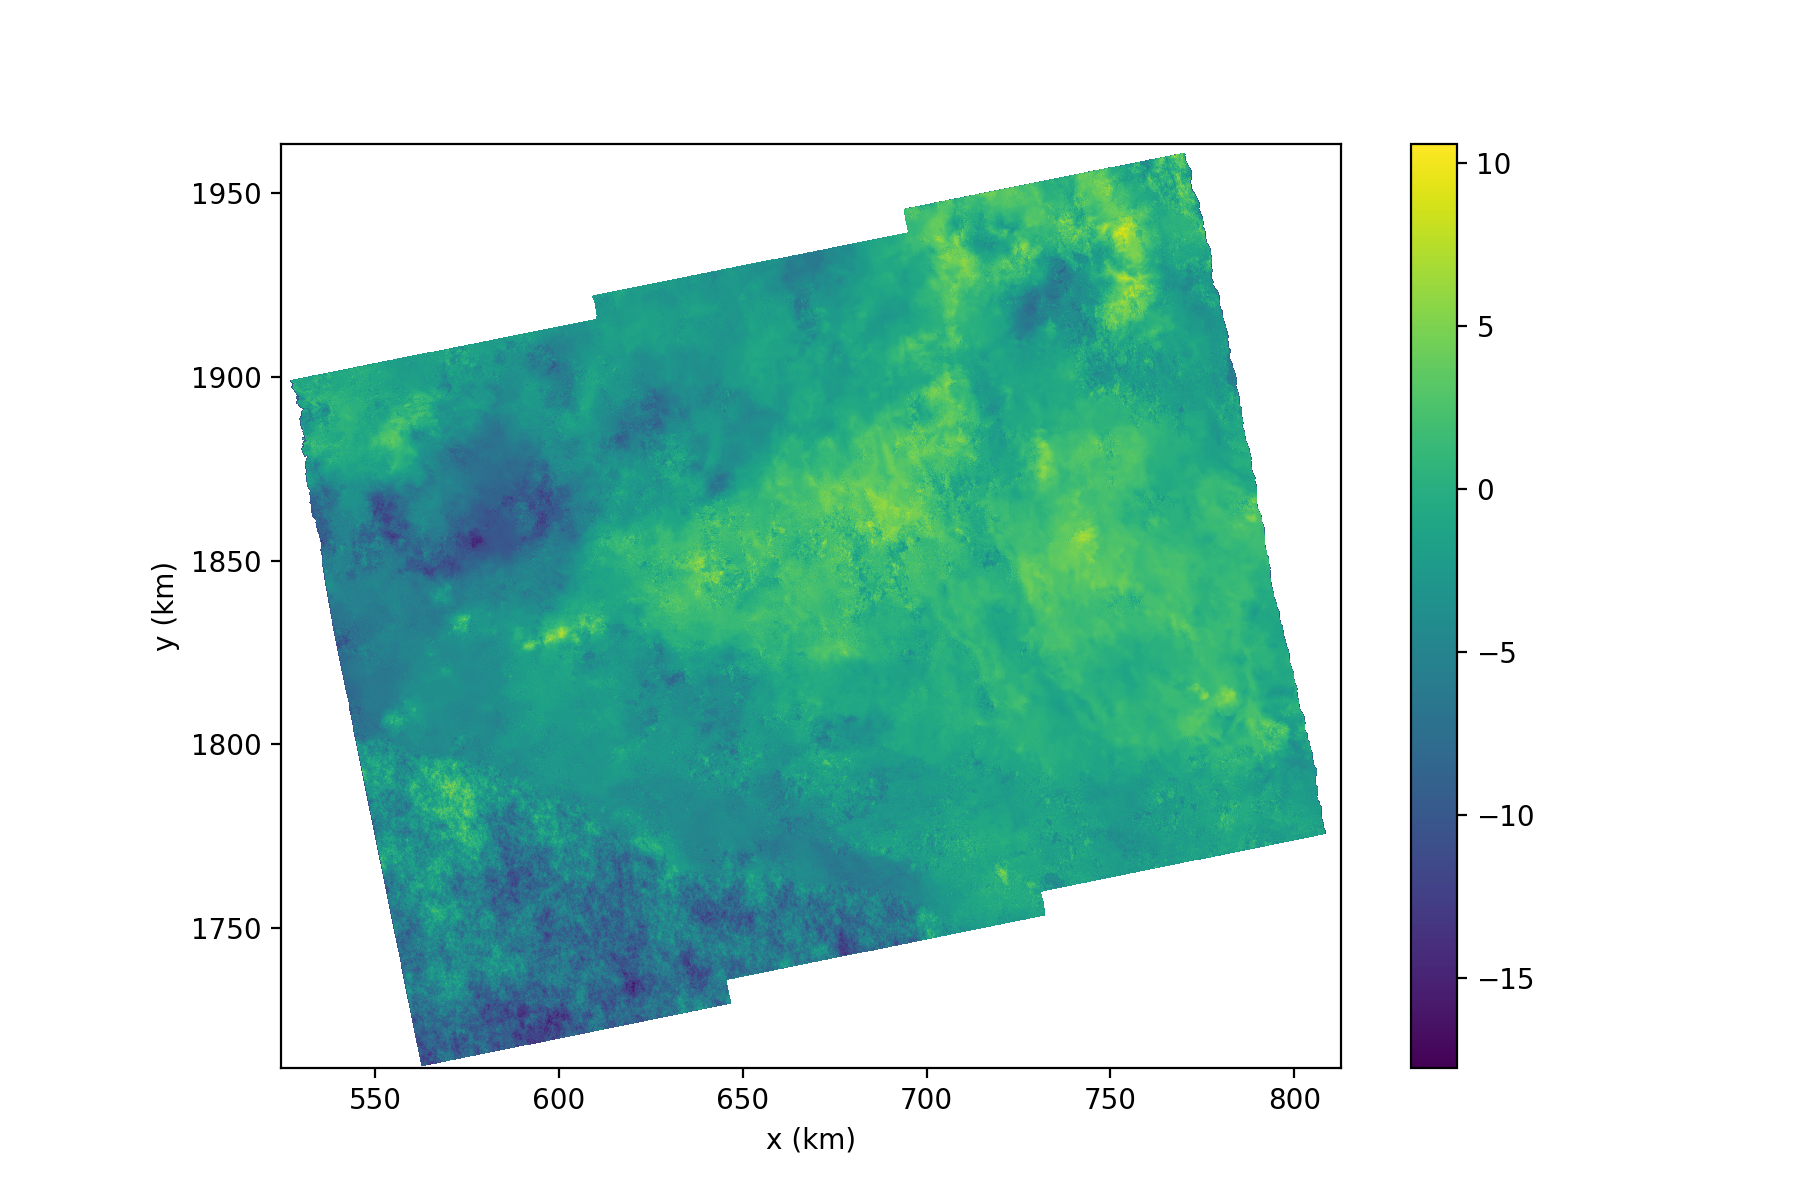

In [4]:
plot_interactive_multiple_slicing(data_array,
                                  [0, 1],
                                  [0, 0],
                                  update_colorbar = True,
                                  extent = data_extent,
                                  xlabel = 'x (km)',
                                  ylabel = 'y (km)',
                                  figsize = (9, 6))

# Define the comparison window

In [5]:
subarray_shape = (128, 128)
pads = (0, 0)

In [6]:
geotransform = (0., data_spacing[1], 0.,
                data_spacing[0]*subarray_shape[0], 0., -data_spacing[0])
extent = (0., data_spacing[1]*subarray_shape[1]/1000.,
          0., data_spacing[0]*subarray_shape[0]/1000.)

In [7]:
j_im = 1000
i_im = 1000

sampled_data_array = data_array[:,
                                :,
                                j_im:j_im + subarray_shape[0],
                                i_im:i_im + subarray_shape[1]]

<IPython.core.display.Javascript object>


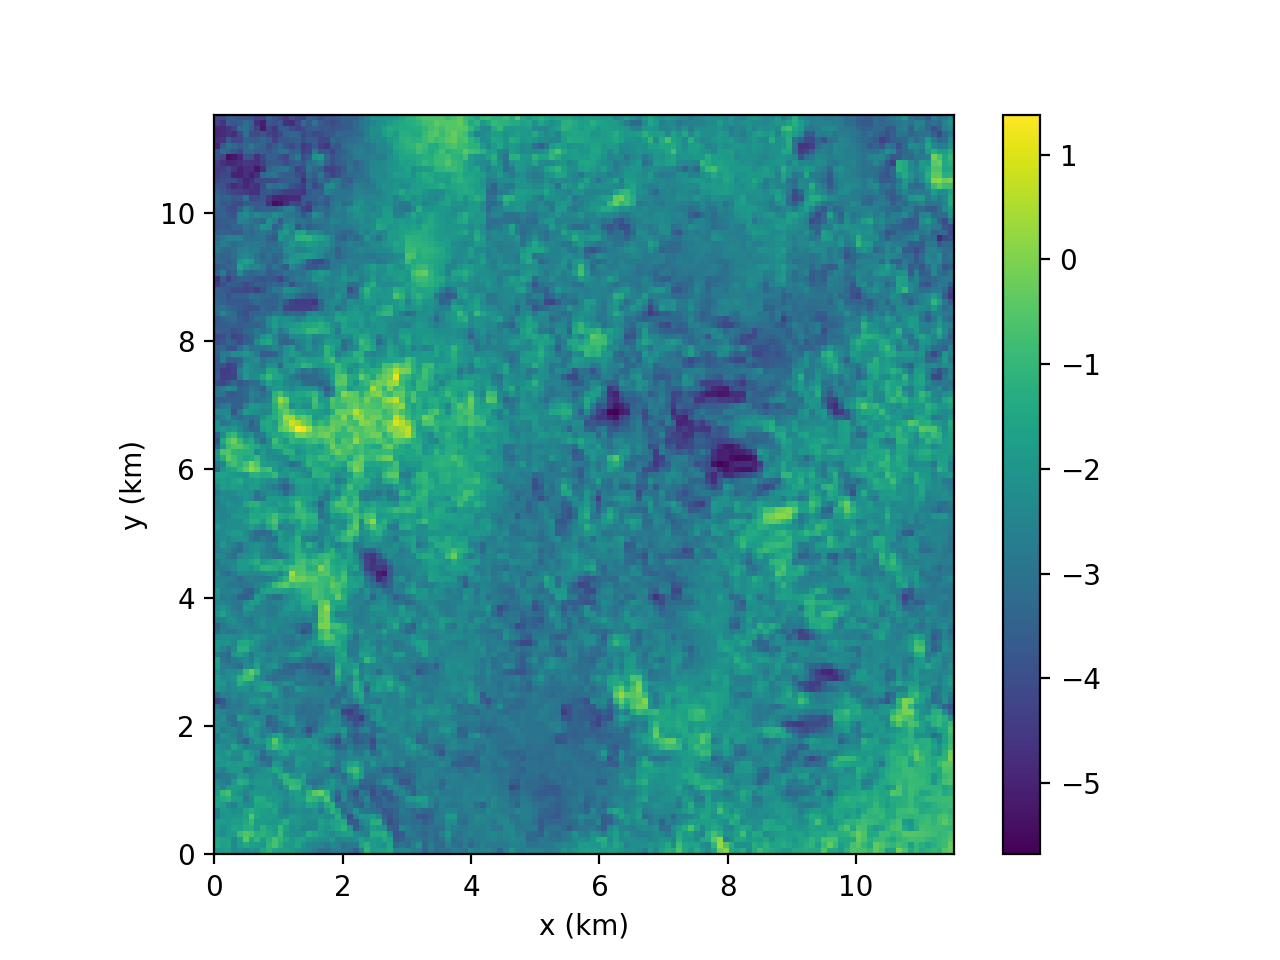

In [8]:
plot_interactive_multiple_slicing(sampled_data_array,
                                  [0, 1],
                                  [0, 0],
                                  extent = extent,
                                  xlabel = 'x (km)',
                                  ylabel = 'y (km)',
                                  update_colorbar = True)

# Extraction and export of the training data

In [9]:
training_folder = 'Machine_Learning/Training_Data/'

output_folder = data_folder + 'Anomaly_Identification/' + training_folder
os.makedirs(output_folder, exist_ok = True)

In [10]:
step_shape = subarray_shape
test_data_proportion = 0.1
validation_data_proportion = 0.1
is_shape_centered = False

seed = 100

In [11]:
%%time

np.random.seed(seed)

for i in range(data_array.shape[0]):
    if i not in excluded_indexes:
        pair_number = str(i + 1)
        samples_array = sample_array(data_array[i],
                                     subarray_shape,
                                     steps = step_shape,
                                     pads = pads,
                                     is_shape_centered = is_shape_centered)
        np.random.shuffle(samples_array)
        
        test_limit = int(test_data_proportion*samples_array.shape[0])
        validation_limit = test_limit + int(validation_data_proportion*samples_array.shape[0])
        
        for j in range(data_array.shape[1]):
            raster_training_data = create_georaster_from_array(samples_array[validation_limit:, j],           
                                                               geotransform, 
                                                               data_projection,
                                                               file_type = 'GTiff',
                                                               file_path = output_folder + 'Training_' + georaster_names[j] + '_' + pair_number + '_DataExtraction_Normal.tif',
                                                               options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
            raster_training_data = None
            raster_training_data = create_georaster_from_array(samples_array[test_limit:validation_limit, j],           
                                                               geotransform, 
                                                               data_projection,
                                                               file_type = 'GTiff',
                                                               file_path = output_folder + 'Validation_' + georaster_names[j] + '_' + pair_number + '_DataExtraction_Normal.tif',
                                                               options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
            raster_training_data = None
            raster_training_data = create_georaster_from_array(samples_array[:test_limit, j],           
                                                               geotransform, 
                                                               data_projection,
                                                               file_type = 'GTiff',
                                                               file_path = output_folder + 'Test_' + georaster_names[j] + '_' + pair_number + '_DataExtraction_Normal.tif',
                                                               options = ['COMPRESS=DEFLATE', 'PREDICTOR=3'])
            raster_training_data = None

CPU times: user 3min 3s, sys: 2.86 s, total: 3min 6s
Wall time: 3min 6s


In [12]:
samples_array.shape

(317, 2, 128, 128)

<IPython.core.display.Javascript object>


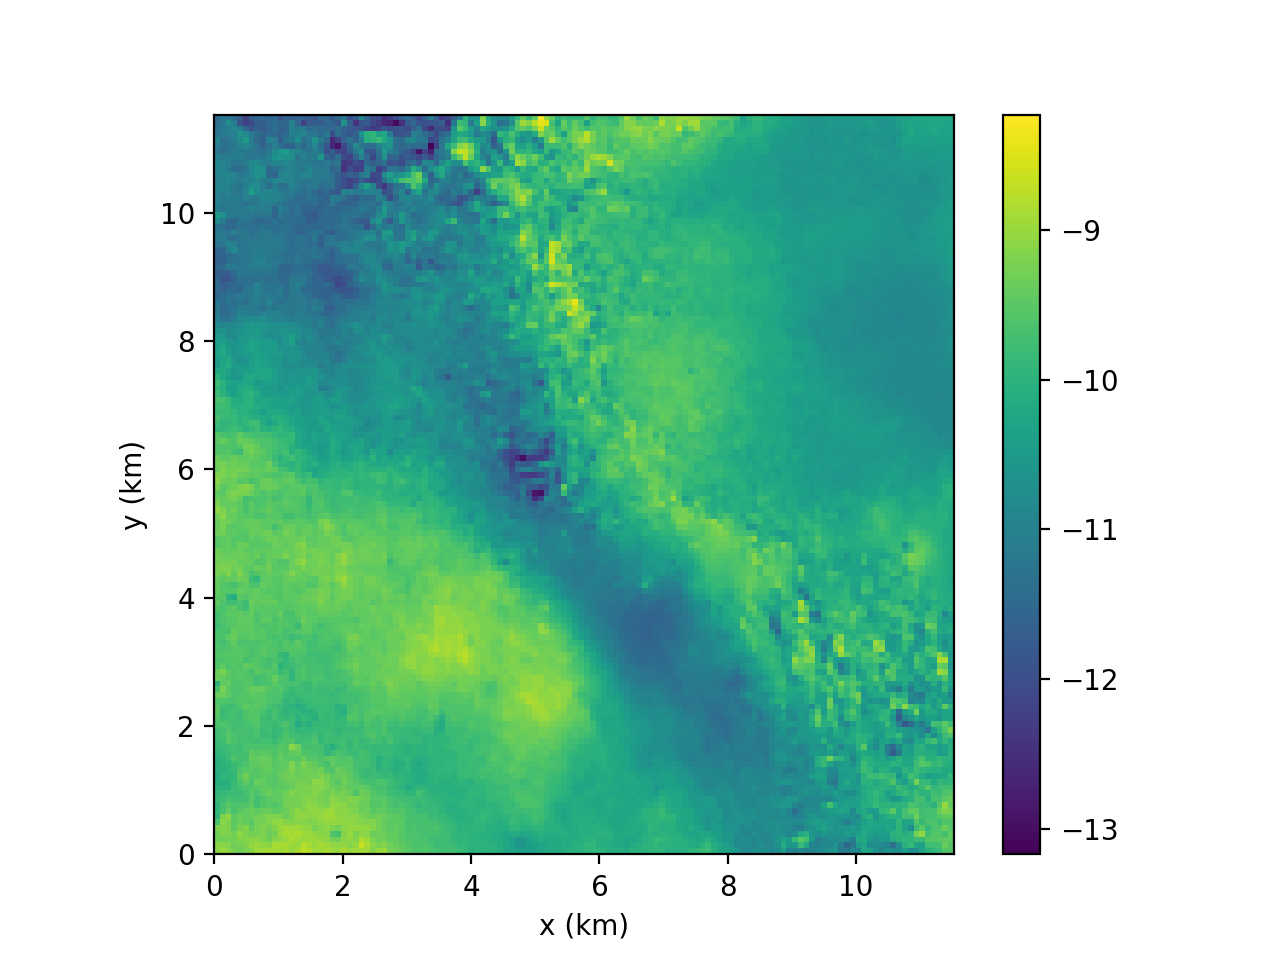

In [13]:
plot_interactive_multiple_slicing(samples_array,
                                  [0, 1],
                                  [0, 0],
                                  extent = extent,
                                  xlabel = 'x (km)',
                                  ylabel = 'y (km)',
                                  update_colorbar = True)